In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import getpass
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import datetime as dt
import copy
from shapely.geometry import Polygon, Point
import random
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
from shapely.geometry import Polygon
from shapely.strtree import STRtree
from tqdm import tqdm
from collections import defaultdict
import scipy
import geopandas as gpd
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from scipy.stats import linregress
# import functions
import get_int_coefs
import get_natural_earth

In [2]:
# Select date of TROPOMI data file (to be replaced by loop etc...)
sdate = dt.datetime(2019,1,1,0)
edate = dt.datetime(2019,1,31,0)

Ipath = "/capstor/scratch/cscs/zhug/Romania6km/simulation_outer_domain"

# Ignore obs above this uncertainty threshold:
prec_threshold = 2.6 # ppb

# Ignore obs below this qa threshold:
qa_threshold = .6

# Ignore obs below this albedo (SWIR) threshold:
albedo_th = 0.05

# Choose spatial extent for plot
minlon, maxlon, minlat, maxlat = 19.30, 30.30, 43.05, 48.75

# Choose range for colormap
vmin, vmax = 1810., 1880.

Mda, MCH4 = 28.964, 16.04

ICON_grid_path = '/capstor/scratch/cscs/zhug/Romania6km/input/grid/outer_grid/dyn_grid.nc'

plotdir = '/capstor/scratch/cscs/zhug/Romania6km/plotting'

if not os.path.exists(plotdir):
  os.makedirs(plotdir)

In [3]:
# Path to TROPOMI data files
Tpath = '/capstor/scratch/cscs/zhug/Romania6km/input/TROPOMI'

# Select files
# Tfiles = [
#     fn for fn in sorted(os.listdir(Tpath))
#     if any(
#         dt.datetime.strftime(date, '_%Y%m%dT') in fn
#         for date in (sdate + dt.timedelta(days=i) for i in range((edate - sdate).days + 1))
#     )
# ]
Tfile = "/capstor/scratch/cscs/zhug/Romania6km/input/TROPOMI/TROPOMI_SRON_corners_20190101_20191231.nc"

ODIN_file = "/capstor/scratch/cscs/zhug/Romania6km/simulation_outer_domain/output_sat_ch4.nc"

In [4]:
ODIN_ds = xr.open_dataset(ODIN_file)


ODIN_ds = ODIN_ds.where(
    (ODIN_ds.date >= np.datetime64(sdate)) &
    (ODIN_ds.date <= np.datetime64(edate)),
    drop=True
)

In [5]:
# Define a function to open and merge groups from a single file

def open_and_prepare_s5p_file(filepath, file_idx):
    groups = [
        "PRODUCT",
        "PRODUCT/SUPPORT_DATA/GEOLOCATIONS",
        "PRODUCT/SUPPORT_DATA/INPUT_DATA",
        "PRODUCT/SUPPORT_DATA/DETAILED_RESULTS",
        "METADATA/QA_STATISTICS"
    ]
    datasets = [
        xr.open_dataset(filepath, group=group)  # Lazy loading with no chunking for now
        for group in groups
    ]
    merged = xr.merge(datasets)
    
    # Add sounding_dim as a new coordinate and dimension
    # Remove the 'time' dimension
    Tdata_no_time = merged.squeeze("time")

    # Merge 'scanline' and 'ground_pixel' into 'sounding_dim'
    Tdata_reshaped = Tdata_no_time.stack(sounding_dim=("scanline", "ground_pixel"))

    # Adjust the order so that 'sounding_dim' iterates over all ground_pixels for each scanline
    Tdata_cleaned = Tdata_reshaped.transpose(..., "sounding_dim")
    
    # Apply filters
    Tdata_cleaned = Tdata_cleaned.where(Tdata_cleaned.qa_value>qa_threshold, drop=True)
    Tdata_cleaned = Tdata_cleaned.where(Tdata_cleaned.surface_albedo_SWIR>albedo_th, drop=True)
    Tdata_cleaned = Tdata_cleaned.where(Tdata_cleaned.methane_mixing_ratio_precision<prec_threshold, drop=True)
    
    return Tdata_cleaned

In [6]:
def open_preprocessed_tropomi(filepath):
    ds = xr.open_dataset(filepath)

    # Apply quality filters, rename if needed
    # ds = ds.where(ds["qa0"] > 0.6, drop=True)
    # ds = ds.where(ds["obserror"] < 2.6, drop=True)

    # Rename for consistency with later code (if expected)
    ds = ds.rename({
        "lat": "latitude",
        "lon": "longitude",
        "obs": "methane_mixing_ratio"  # guess — adjust as needed
    })

    return ds

In [7]:
# Process and prepare each file
# Tdata_list = [
#     open_and_prepare_s5p_file(os.path.join(Tpath, f), idx)
#     for idx, f in enumerate(Tfiles)
# ]

# Concatenate across sounding_dim
# Tdata = xr.concat(Tdata_list, dim="sounding_dim")

Tdata = open_preprocessed_tropomi(Tfile)

In [8]:
# Open ICON grid file
ICONgrid = xr.open_dataset(ICON_grid_path)

In [9]:
# Path to CAMS data files
Cpath = '/capstor/scratch/cscs/zhug/Romania6km/input/CAMS/LBC'

# CAMS file that contains the hyam and hybm parameters (constants)
pfile = '/capstor/scratch/cscs/zhug/Romania6km/input/CAMS/cams73_v22r2_ch4_conc_surface_inst_201910.nc'

# Open CAMS file with xarray
pdata = xr.open_dataset(pfile)

hyam = pdata.hyam.values
hybm = pdata.hybm.values

hyai = pdata.hyai.values
hybi = pdata.hybi.values


In [10]:
# Match obs with ICON grid cells, i.e. limit the obs to the one inside the model domain:
gridvlon = np.rad2deg(ICONgrid.vlon.values)
gridvlat = np.rad2deg(ICONgrid.vlat.values)
progclon = np.rad2deg(ICONgrid.clon.values[ICONgrid.refin_c_ctrl.values>4])
progclat = np.rad2deg(ICONgrid.clat.values[ICONgrid.refin_c_ctrl.values>4])
inside_domain = (
    (Tdata.longitude >= np.nanmin(progclon)) & (Tdata.longitude <= np.nanmax(progclon)) &
    (Tdata.latitude >= np.nanmin(progclat)) & (Tdata.latitude <= np.nanmax(progclat))
)
Tdata_filtered = Tdata.where(inside_domain, drop=True)


In [11]:
# Drop observations (sounding_dim) where all values are NaN in the specified variable
# Tdata_cleaned = Tdata_filtered.dropna(
#     dim="sounding_dim", 
#     subset=["methane_mixing_ratio_bias_corrected"]
# )
Tdata_cleaned = Tdata_filtered
Tdata_cleaned = Tdata_filtered.where(
    (Tdata_filtered.date >= np.datetime64(sdate)) &
    (Tdata_filtered.date <= np.datetime64(edate)),
    drop=True
)


In [12]:
# Define matching tolerances
time_tol = np.timedelta64(30, 's')       # within 30 seconds
coord_tol = 1e-5                         # ~1 meter precision

matched_ODIN = np.full(Tdata_cleaned.dims['index'], np.nan)
odin_time_vals = pd.to_datetime(ODIN_ds.date.values)
odin_lat_vals = ODIN_ds.lat.values
odin_lon_vals = ODIN_ds.lon.values
odin_ch4_vals = ODIN_ds.CH4.values

for i, (t_time, t_lat, t_lon) in enumerate(zip(
        pd.to_datetime(Tdata_cleaned.date.values),
        Tdata_cleaned.latitude.values,
        Tdata_cleaned.longitude.values)):

    # Find indices where time, lat, lon match within tolerance
    match_mask = (
        (np.abs(odin_time_vals - t_time) <= time_tol) &
        (np.abs(odin_lat_vals - t_lat) <= coord_tol) &
        (np.abs(odin_lon_vals - t_lon) <= coord_tol)
    )

    if np.any(match_mask):
        matched_ODIN[i] = odin_ch4_vals[match_mask][0]  # take first exact match
    # else: remains NaN by default

# Add result to dataset
Tdata_cleaned['ODIN_values'] = xr.DataArray(matched_ODIN, dims=["index"])


/tmp/ipykernel_100552/1921595307.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  matched_ODIN = np.full(Tdata_cleaned.dims['index'], np.nan)


In [13]:
# Precompute datetimes
time_values = Tdata_cleaned.date.values
# obs_time_dts = [
#     dt.datetime.strptime(obs_time,'%Y-%m-%dT%H:%M:%S.%fZ') for obs_time in time_values
# ]
obs_time_dts = [pd.Timestamp(obs_time).to_pydatetime() for obs_time in time_values]

In [14]:
# Pre-open ICON output

first_ICON_date = Tdata_cleaned.date.values[0]
# first_ICON_date = dt.datetime.strptime(first_ICON_date, "%Y-%m-%dT%H:%M:%S.%fZ")
first_ICON_date = pd.Timestamp(Tdata_cleaned.date.values[0]).to_pydatetime()
first_ICON_date = first_ICON_date.replace(minute=0, second=0, microsecond=0)

last_ICON_date = Tdata_cleaned.date.values[-1]
# last_ICON_date = dt.datetime.strptime(last_ICON_date, "%Y-%m-%dT%H:%M:%S.%fZ")
last_ICON_date = pd.Timestamp(Tdata_cleaned.date.values[-1]).to_pydatetime()
last_ICON_date = last_ICON_date.replace(minute=0,second=0,microsecond=0)
last_ICON_date = last_ICON_date + dt.timedelta(hours=1)

# Open the datasets dynamically
model_datasets = {}  # Use a dictionary to store datasets
loopdate = first_ICON_date
counter = 0

while loopdate <= last_ICON_date:
    print(loopdate)
    # Path to ICON data files
    datestring = dt.datetime.strftime(loopdate,'%Y-%m-%d_00-00')
    
    
    # find closest observation to this loopdate:
    closest_obsdate = min(obs_time_dts, key=lambda x: abs(x - loopdate))
    # Calculate the time difference
    time_diff = abs(closest_obsdate - loopdate)
    # Skip loopdate if the nearest entry is more than 3 hours away
    if time_diff <= dt.timedelta(hours=3):
        # print(f"Processing: {loopdate} (Closest: {closest_obsdate}, Difference: {time_diff})")
        pass
    else:
        print(f"Skipping: {loopdate} (Closest: {closest_obsdate}, Difference: {time_diff})")
        loopdate += dt.timedelta(hours=1)
        continue

    Ifile = dt.datetime.strftime(loopdate,'ICON-ART-UNSTR_%Y-%m-%dT%H:00:00.000.nc') 
    # Ifile = dt.datetime.strftime(loopdate,'OUTPUT__%Y%m%dT%H0000Z.nc')
    
    Idata = xr.open_dataset(os.path.join(Ipath,Ifile),engine='netcdf4')
    Idata = Idata.assign(CH4_EMIS_dry=Idata.CH4_EMIS/(1.-Idata.qv))
    
    model_datasets[loopdate.year,loopdate.month,loopdate.day,loopdate.hour] = Idata

    print('opened %s'%Ifile)
    loopdate += dt.timedelta(hours=1)

2019-01-01 11:00:00
opened ICON-ART-UNSTR_2019-01-01T11:00:00.000.nc
2019-01-01 12:00:00
opened ICON-ART-UNSTR_2019-01-01T12:00:00.000.nc
2019-01-01 13:00:00
opened ICON-ART-UNSTR_2019-01-01T13:00:00.000.nc
2019-01-01 14:00:00
opened ICON-ART-UNSTR_2019-01-01T14:00:00.000.nc
2019-01-01 15:00:00
Skipping: 2019-01-01 15:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 3:45:04.931000)
2019-01-01 16:00:00
Skipping: 2019-01-01 16:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 4:45:04.931000)
2019-01-01 17:00:00
Skipping: 2019-01-01 17:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 5:45:04.931000)
2019-01-01 18:00:00
Skipping: 2019-01-01 18:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 6:45:04.931000)
2019-01-01 19:00:00
Skipping: 2019-01-01 19:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 7:45:04.931000)
2019-01-01 20:00:00
Skipping: 2019-01-01 20:00:00 (Closest: 2019-01-01 11:14:55.069000, Difference: 8:45:04.931000)
2019-01-01 21:00:00
Skipping

In [15]:
# Pre-open CAMS file column_averaging_kernel

first_CAMS_date = first_ICON_date.replace(hour=(first_ICON_date.hour//6)*6)
last_CAMS_date = last_ICON_date.replace(hour=(last_ICON_date.hour//6)*6 + 6)

cams_pressures = {}
cams_profiles = {}
cams_interfaces = {}

loopdate = first_CAMS_date
while loopdate <= last_CAMS_date:    
    
    
    # find closest observation to this loopdate:
    closest_obsdate = min(obs_time_dts, key=lambda x: abs(x - loopdate))
    # Calculate the time difference
    time_diff = abs(closest_obsdate - loopdate)
    # Skip loopdate if the nearest entry is more than 7 hours away
    if time_diff <= dt.timedelta(hours=7):
        # print(f"Processing: {loopdate} (Closest: {closest_obsdate}, Difference: {time_diff})")
        pass
    else:
        print(f"Skipping: {loopdate} (Closest: {closest_obsdate}, Difference: {time_diff})")
        loopdate += dt.timedelta(hours=6)
        continue


    Cfile = dt.datetime.strftime(loopdate,'cams73_v22r2_ch4_conc_surface_inst_%Y%m%d%H.nc')
    Cdata = xr.open_dataset(os.path.join(Cpath,Cfile))

    aps = Cdata.ps.values[0,...]
    CAMS_CH4 = Cdata.CH4.values[0,...]
    CAMS_pressures = np.zeros(( aps.shape[0] , hyam.shape[0] ))
    CAMS_interfaces = np.zeros(( aps.shape[0] , hyai.shape[0] ))
    for ii in np.arange(aps.shape[0]):
        CAMS_pressures[ii,:] = ( hyam[:]+hybm[:]*aps[ii] ) / 1.e2
        CAMS_interfaces[ii,:] = ( hyai[:]+hybi[:]*aps[ii] ) / 1.e2

    key = (loopdate.year, loopdate.month, loopdate.day, loopdate.hour)
    cams_pressures[key] = CAMS_pressures
    cams_profiles[key] = CAMS_CH4
    cams_interfaces[key] = CAMS_interfaces

    print('opened %s'%Cfile)
    loopdate += dt.timedelta(hours=6)

opened cams73_v22r2_ch4_conc_surface_inst_2019010106.nc
opened cams73_v22r2_ch4_conc_surface_inst_2019010112.nc
opened cams73_v22r2_ch4_conc_surface_inst_2019010118.nc
Skipping: 2019-01-02 00:00:00 (Closest: 2019-01-02 10:55:22.259000, Difference: 10:55:22.259000)
opened cams73_v22r2_ch4_conc_surface_inst_2019010206.nc
opened cams73_v22r2_ch4_conc_surface_inst_2019010212.nc
Skipping: 2019-01-02 18:00:00 (Closest: 2019-01-02 10:56:41.097000, Difference: 7:03:18.903000)
Skipping: 2019-01-03 00:00:00 (Closest: 2019-01-03 10:37:07.727000, Difference: 10:37:07.727000)
opened cams73_v22r2_ch4_conc_surface_inst_2019010306.nc
opened cams73_v22r2_ch4_conc_surface_inst_2019010312.nc
Skipping: 2019-01-03 18:00:00 (Closest: 2019-01-03 10:37:08.807000, Difference: 7:22:51.193000)
Skipping: 2019-01-04 00:00:00 (Closest: 2019-01-03 10:37:08.807000, Difference: 13:22:51.193000)
Skipping: 2019-01-04 06:00:00 (Closest: 2019-01-03 10:37:08.807000, Difference: 19:22:51.193000)
Skipping: 2019-01-04 12:00:0

In [16]:
# Corner of selected observations
corners_obs_sel = np.zeros((len(Tdata_cleaned.date),4,2))
corners_obs_sel[...,0] = Tdata_cleaned.longitude_bounds.T.values
corners_obs_sel[...,1] = Tdata_cleaned.latitude_bounds.T.values

In [17]:
# Corners of ICON-Grid
voc = ICONgrid.vertex_of_cell.values
corners_icon = np.zeros((ICONgrid.sizes['cell'],3,2))
for ncell in np.arange(ICONgrid.sizes['cell']):
    vert_ind = voc[:,ncell] - 1
    for ic in np.arange(3):
        corners_icon[ncell,ic,:] = gridvlon[vert_ind[ic]] , gridvlat[vert_ind[ic]]

In [18]:
# Open extpar and parent grid
ICONextp = xr.open_dataset('/capstor/scratch/cscs/zhug/Romania6km/input/grid/outer_grid/extpar_file.nc')
ICONparent = xr.open_dataset('/capstor/scratch/cscs/zhug/Romania6km/input/grid/outer_grid/parent_grid.nc')

In [19]:
Tdata_cleaned

<xarray.Dataset> Size: 845kB
Dimensions:               (index: 2113, level: 12, level_pressure: 13, corner: 4)
Coordinates:
  * index                 (index) int64 17kB 0 1 2 3 4 ... 2109 2110 2111 2112
  * level                 (level) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * level_pressure        (level_pressure) int64 104B 0 1 2 3 4 ... 8 9 10 11 12
  * corner                (corner) int64 32B 0 1 2 3
Data variables: (12/16)
    qa0                   (index, level) float32 101kB 2.061e+03 ... 1.22e+03
    ak                    (index, level) float32 101kB 1.11 1.106 ... 0.6373
    pw                    (index, level) float64 203kB 0.08333 ... 0.08333
    pavg0                 (index, level_pressure) float64 220kB 999.5 ... 0.1001
    date                  (index) datetime64[ns] 17kB 2019-01-01T11:14:35.629...
    duration              (index) float64 17kB 1e-08 1e-08 1e-08 ... 1e-08 1e-08
    ...                    ...
    latitude              (index) float32 8kB 44.94 44.92 44.94 ... 45.99 46.07
    methane_mixing_ratio  (index) float32 8kB 1.854e+03 1.854e+03 ... 1.857e+03
    obserror              (index) float32 8kB 32.3 32.32 32.38 ... 32.49 32.56
    latitude_bounds       (corner, index) float32 34kB 44.9 44.88 ... 46.09
    longitude_bounds      (corner, index) float32 34kB 25.86 25.4 ... 28.73
    ODIN_values           (index) float64 17kB 1.859e+03 1.858e+03 ... 1.846e+03

In [20]:
# Map TROPOMI to the ICON grid cells

longitude_corners = Tdata_cleaned.longitude_bounds.T.values
latitude_corners = Tdata_cleaned.latitude_bounds.T.values
# xch4 = Tdata_cleaned.methane_mixing_ratio_bias_corrected.values
xch4 = Tdata_cleaned.methane_mixing_ratio.values
xch4_unc = Tdata_filtered.obserror.values
xch4_odin = Tdata_cleaned.ODIN_values.values
xch4_odin_unc = Tdata_filtered.obserror.values
voc = ICONgrid.vertex_of_cell.values

tropomi2icon_ids = {}

ntri = corners_icon.shape[0]
remapped_xch4 = np.zeros(ntri)
remapped_error = np.zeros(ntri)
remapped_xch4_odin = np.zeros(ntri)
remapped_error_odin = np.zeros(ntri)
weight_sum = np.zeros(ntri)

# Build ICON-ART cell polygons and an R-tree
icon_polygons = [Polygon(zip(corners_icon[i,:,0], corners_icon[i,:,1])) for i in range(corners_icon.shape[0])]
tree = STRtree(icon_polygons)
icon_index = {id(polygon): i for i, polygon in enumerate(icon_polygons)}  # Map polygons to indices

# Loop over TROPOMI observations
for i in tqdm(range(len(xch4)),desc='remapping TROPOMI obs'):
    tropomi2icon_ids[i] = []
    try:
        tropomi_polygon = Polygon(zip(longitude_corners[i,:], latitude_corners[i,:]))
    except:
        continue

    # Query R-tree for potential overlaps
    possible_matches = tree.query(tropomi_polygon)

    for match in possible_matches:
        if tropomi_polygon.intersects(icon_polygons[match]):
            overlap_area = tropomi_polygon.intersection(icon_polygons[match]).area
            remapped_xch4[match] += xch4[i] * overlap_area
            remapped_error[match] += xch4_unc[i] * overlap_area
            remapped_xch4_odin[match] += xch4_odin[i] * overlap_area
            remapped_error_odin[match] += xch4_odin_unc[i] * overlap_area
            weight_sum[match] += overlap_area

            # if a ICON cell is at least covered by 50% with the obs, then count this cell
            # if (overlap_area / icon_polygons[match].area) >= 0.5:
            if (overlap_area) > 0.0:
                tropomi2icon_ids[i] = np.append(tropomi2icon_ids[i],int(match))

remapped_xch4[weight_sum>0.] = remapped_xch4[weight_sum>0.] / weight_sum[weight_sum>0.]
remapped_error[weight_sum>0.] = remapped_error[weight_sum>0.] / weight_sum[weight_sum>0.]

remapped_xch4_odin[weight_sum>0.] = remapped_xch4_odin[weight_sum>0.] / weight_sum[weight_sum>0.]
remapped_error_odin[weight_sum>0.] = remapped_error_odin[weight_sum>0.] / weight_sum[weight_sum>0.]

remapped_xch4[remapped_xch4==0.] = np.nan
remapped_error[remapped_error==0.] = np.nan
remapped_xch4_odin[remapped_xch4_odin==0.] = np.nan
remapped_error_odin[remapped_error_odin==0.] = np.nan

remapping TROPOMI obs: 100%|██████████| 2113/2113 [00:01<00:00, 2099.69it/s]


In [21]:
print(len(Tdata_cleaned.date))

2113


In [22]:
# Calculate interface pressures
# Start with surface pressure, subtract cumulative sums of pressure intervals
# interface_pressures = np.zeros((Tdata_cleaned.dims['sounding_dim'], Tdata_cleaned.dims['level']))
interface_pressures = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level_pressure']))
pwfs = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level']))
qa0s = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level']))
aks = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level']))

# for i, (sp, pi) in enumerate(zip(Tdata_cleaned.surface_pressure.values, Tdata_cleaned.pressure_interval.values)):
#     interface_pressures[i, 0] = sp / 100.
#     interface_pressures[i, 1:] = (sp - np.arange(1, Tdata_cleaned.dims['level']) * pi) / 100.

interface_pressures = Tdata_cleaned.pavg0.values
pwfs = Tdata_cleaned.pw.values
qa0s = Tdata_cleaned.qa0.values
aks = Tdata_cleaned.ak.values

/tmp/ipykernel_100552/2840952776.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  interface_pressures = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level_pressure']))
/tmp/ipykernel_100552/2840952776.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pwfs = np.zeros((len(Tdata_cleaned.date), Tdata_cleaned.dims['level']))
/tmp/ipykernel_100552/2840952776.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, p

In [23]:
tc = []
tc_omv = [] # get the OMV-signal only in the profile

# Preallocate arrays to avoid appending repeatedly
gridindices = []
obsindices = []
tcindices = []
ncount = 0

cams_prevs = [
    obs_time_dt.replace(hour=(first_ICON_date.hour // 6) * 6, minute=0, second=0, microsecond=0)
    for obs_time_dt in obs_time_dts
]
cams_nexts = [cams_prev + dt.timedelta(hours=6) for cams_prev in cams_prevs]

# Compute fractions in one go
fracs_cams = [
    (obs_time_dt - cams_prev).total_seconds() / (cams_next - cams_prev).total_seconds()
    for obs_time_dt, cams_prev, cams_next in zip(obs_time_dts, cams_prevs, cams_nexts)
]

# Preload pressure profiles to avoid repeatedly extracting them
model_data_cache = {}
cams_pressure_cache = {}
cams_interface_cache = {}
cams_profile_cache = {}

for nobs, obs_time_dt in tqdm(enumerate(np.array(obs_time_dts)),desc='Processing ICON dolumns'):

    # Precompute temporal indices
    time_prev = obs_time_dt.replace(minute=0, second=0, microsecond=0)
    time_next = time_prev + dt.timedelta(hours=1)
    frac = obs_time_dt.minute / 60
    frac_cams = fracs_cams[nobs]

    try:
        mindices = tropomi2icon_ids[nobs].astype(int)
    except:
        continue
    if len(mindices) == 1: continue

    # Preload and cache data
    key_prev = (time_prev.year, time_prev.month, time_prev.day, time_prev.hour)
    key_next = (time_next.year, time_next.month, time_next.day, time_next.hour)
    if key_prev not in model_data_cache:
        model_data_cache[key_prev] = model_datasets[key_prev]
    if key_next not in model_data_cache:
        model_data_cache[key_next] = model_datasets[key_prev]
    # print(f"mindicies: {mindices}, pres_ifc shape: {(model_data_cache[key_prev].pres_ifc[:, ::-1, :].values).shape}")
    # if np.any(mindices >= model_data_cache[key_prev].pres_ifc[0, ::-1, :].shape[-1]):
    #     continue
    pb_mod_prev = np.nanmean(model_data_cache[key_prev].pres_ifc[0, ::-1, mindices].values,axis=1) / 1.e2
    pb_mod_next = np.nanmean(model_data_cache[key_next].pres_ifc[0, ::-1, mindices].values,axis=1) / 1.e2
    pb_mod_mc_prev = np.nanmean(model_data_cache[key_prev].pres[0, ::-1, mindices].values,axis=1) / 1.e2
    pb_mod_mc_next = np.nanmean(model_data_cache[key_next].pres[0, ::-1, mindices].values,axis=1) / 1.e2
    pb_mod = (1. - frac) * pb_mod_prev + frac * pb_mod_next
    pb_mod_mc = (1. - frac) * pb_mod_mc_prev + frac * pb_mod_mc_next

    if np.any(np.isnan(pb_mod)):
        continue

    key_cams_prev = (cams_prevs[nobs].year, cams_prevs[nobs].month, cams_prevs[nobs].day, cams_prevs[nobs].hour)
    key_cams_next = (cams_nexts[nobs].year, cams_nexts[nobs].month, cams_nexts[nobs].day, cams_nexts[nobs].hour)
    if key_cams_prev not in cams_pressure_cache:
        cams_pressure_cache[key_cams_prev] = cams_pressures[key_cams_prev]
        cams_profile_cache[key_cams_prev] = cams_profiles[key_cams_prev]
        cams_interface_cache[key_cams_prev] = cams_interfaces[key_cams_prev]
    if key_cams_next not in cams_pressure_cache:
        cams_pressure_cache[key_cams_next] = cams_pressures[key_cams_next]
        cams_profile_cache[key_cams_next] = cams_profiles[key_cams_next]
        cams_interface_cache[key_cams_next] = cams_interfaces[key_cams_next]

    CAMS_p_prev = np.nanmean(cams_pressure_cache[key_cams_prev][mindices],axis=0)
    CAMS_p_next = np.nanmean(cams_pressure_cache[key_cams_next][mindices],axis=0)
    CAMS_pressures = (1. - frac_cams) * CAMS_p_prev + frac_cams * CAMS_p_next

    CAMS_i_prev = np.nanmean(cams_interface_cache[key_cams_prev][mindices],axis=0)
    CAMS_i_next = np.nanmean(cams_interface_cache[key_cams_next][mindices],axis=0)
    CAMS_interfaces = (1. - frac_cams) * CAMS_i_prev + frac_cams * CAMS_i_next

    CAMS_obs_prev = np.nanmean(cams_profile_cache[key_cams_prev][:, mindices],axis=1)
    CAMS_obs_next = np.nanmean(cams_profile_cache[key_cams_next][:, mindices],axis=1)
    
    
    camsidx_vert = CAMS_pressures < np.min(pb_mod)
    
    ICON_profile_prev = (
        1.0 * (Mda / MCH4) * np.nanmean(model_data_cache[key_prev].CH4_BG.values[0, ::-1, mindices].T,axis=1) +
        1.e9 * (Mda / MCH4) * np.nanmean(model_data_cache[key_prev].CH4_EMIS.values[0, ::-1, mindices].T,axis=1)
    )
    ICON_profile_next = (
        1.0 * (Mda / MCH4) * np.nanmean(model_data_cache[key_next].CH4_BG.values[0, ::-1, mindices].T,axis=1) +
        1.e9 * (Mda / MCH4) * np.nanmean(model_data_cache[key_next].CH4_EMIS.values[0, ::-1, mindices].T,axis=1)
    )
    
    ICON_profile = (1. - frac) * ICON_profile_prev + frac * ICON_profile_next

    CAMS_obs = (1. - frac_cams) * CAMS_obs_prev + frac_cams * CAMS_obs_next
    CAMS_profile = CAMS_obs[CAMS_pressures < np.min(pb_mod)]
    pb_cams = CAMS_interfaces[1:][camsidx_vert]
    pb_cams_mc = CAMS_pressures[:][camsidx_vert]

    tracer_profile = np.concatenate((ICON_profile, CAMS_profile))

    pb_profile = np.concatenate((pb_mod, pb_cams))
    pb_mc_profile = np.concatenate((pb_mod_mc, pb_cams_mc))

    pb_ret = interface_pressures[nobs]

    # pwf = np.abs(np.diff(pb_ret) / np.ptp(pb_ret))
    pwf = pwfs[nobs]
    averaging_kernel = aks[nobs]
    qa0 = qa0s[nobs]

    if pb_ret[0] < pb_ret[-1]:
        pb_ret = pb_ret[::-1]
        pwf = pwf[::-1]
        averaging_kernel = averaging_kernel[::-1]
        qa0 = qa0[::-1]

    coef_matrix = get_int_coefs.get_int_coefs(pb_ret, pb_profile)
    

    avpw = pwf * averaging_kernel
    # prior_col = np.dot(pwf, 1.e9*(Tdata_cleaned.methane_profile_apriori[::-1,nobs].values / Tdata_cleaned.dry_air_subcolumns[::-1,nobs].values))
    prior_col = np.dot(pwf, qa0)

    profile_intrp = np.matmul(coef_matrix, tracer_profile)

    tc = np.append(tc,
        prior_col + np.dot(
        avpw,
        profile_intrp - qa0
        )
    )


    gridindices.append(mindices)
    obsindices.append(nobs)
    tcindices.append(ncount)
    ncount += 1

    

# Convert lists to arrays
gridindices = np.array(gridindices, dtype=object)
obsindices = np.array(obsindices, dtype=int)
tcindices = np.array(tcindices, dtype=int)
# gridindices = np.array(gridindices, dtype=int)
# obsindices = np.array(obsindices, dtype=int)
# tcindices = np.array(tcindices, dtype=int)

Processing ICON dolumns: 2113it [00:28, 73.54it/s]


In [24]:
print(tc)

[1855.73735134 1857.63500232 1856.7760847  ... 1846.49385656 1847.29269262
 1845.81261766]


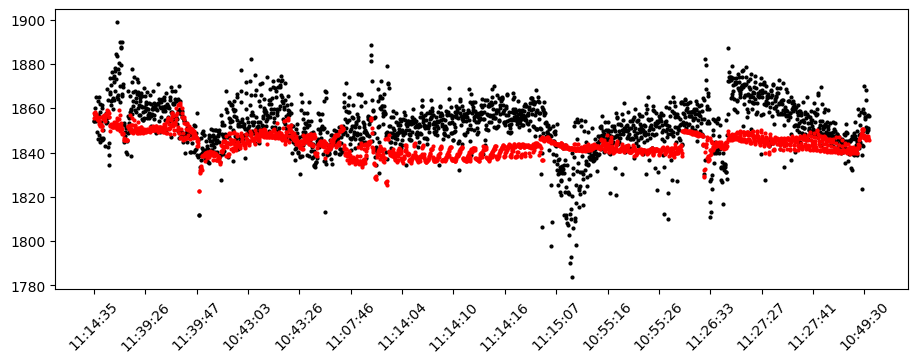

In [25]:
# Time series as scatter plot

# ddt = int(Tdata_cleaned.methane_mixing_ratio_bias_corrected[obsindices].size/15)
ddt = int(Tdata_cleaned.methane_mixing_ratio[obsindices].size/15)
fig, ax = plt.subplots(1, 1, figsize=(11,4))
# plt.scatter(
#     np.arange(Tdata_cleaned.methane_mixing_ratio_bias_corrected[obsindices].size),
#     Tdata_cleaned.methane_mixing_ratio_bias_corrected[obsindices].values,
#     c='k',s=4.,
#     );
plt.scatter(
    np.arange(Tdata_cleaned.methane_mixing_ratio[obsindices].size),
    Tdata_cleaned.methane_mixing_ratio[obsindices].values,
    c='k',s=4.,
    );
# plt.scatter(
#     np.arange(Tdata_cleaned.methane_mixing_ratio_bias_corrected[obsindices].size),
#     tc[tcindices],
#     c='r',s=4.,
#     );
plt.scatter(
    np.arange(Tdata_cleaned.methane_mixing_ratio[obsindices].size),
    tc[tcindices],
    c='r',s=4.,
    );
# plt.xticks(
#     np.arange(Tdata_cleaned.methane_mixing_ratio_bias_corrected[obsindices].size)[::ddt],
#     [dt.datetime.strftime(x,'%H:%M:%S') for x in \
#         pd.to_datetime(Tdata_cleaned.time_utc[obsindices])[::ddt]],
#     rotation=45
#     );
plt.xticks(
    np.arange(Tdata_cleaned.methane_mixing_ratio[obsindices].size)[::ddt],
    [dt.datetime.strftime(x,'%H:%M:%S') for x in \
        pd.to_datetime(Tdata_cleaned.date[obsindices])[::ddt]],
    rotation=45
    );
plt.subplots_adjust(bottom=0.18)
plt.show()


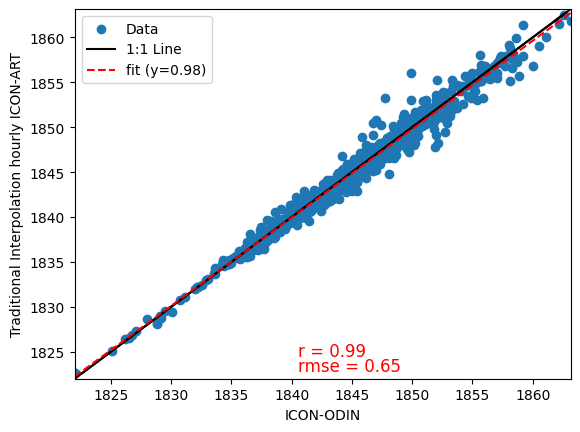

In [31]:
# Scater plot

# x = Tdata_cleaned.methane_mixing_ratio[obsindices].values
x = Tdata_cleaned.ODIN_values[obsindices].values
y = tc[tcindices]

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)  # Create a mask for valid (non-NaN) entries
x_clean = x[mask]
y_clean = y[mask]

sorted_indices = np.argsort(x_clean)
x_sorted = x_clean[sorted_indices]
y_sorted = y_clean[sorted_indices]

x_clean = x_sorted
y_clean = y_sorted

# Fit a line (linear regression) with cleaned data
coeffs = np.polyfit(x_clean, y_clean, 1)  # First-order polynomial (linear fit)
slope, intercept = coeffs  # Slope (m) and intercept (b)
fitted_line = np.polyval(coeffs, x_clean)

# Compute the correlation coefficient
correlation_matrix = np.corrcoef(x_clean, y_clean)
r = correlation_matrix[0, 1]  # Extract correlation coefficient
rmse = np.sqrt(np.mean((x_clean - y_clean) ** 2))

fig, ax = plt.subplots()

# Plot scatter plot
plt.scatter(x_clean, y_clean, label="Data")
plt.plot(y_clean, y_clean, c='k')
plt.plot(x_clean, x_clean, c='k', label="1:1 Line")

# Add fitted line
plt.plot(x_clean, fitted_line, linestyle='--', color='red', label=f"fit (y={slope:.2f})")

# Add correlation coefficient as text
plt.text(0.45, 0.06, f'r = {r:.2f}', transform=ax.transAxes, color='red', fontsize=12)
plt.text(0.45, 0.02, f'rmse = {rmse:.2f}', transform=ax.transAxes, color='red', fontsize=12)

plt.xlim([np.nanmin([y_clean,x_clean]),np.nanmax([y_clean,x_clean])])
plt.ylim([np.nanmin([y_clean,x_clean]),np.nanmax([y_clean,x_clean])])

# Add legend and labels
plt.xlabel("ICON-ODIN")
plt.ylabel("Traditional Interpolation hourly ICON-ART")
plt.legend()
plt.show()


In [27]:
from collections import defaultdict

# Precompute the mapping of grididx to tc indices
grididx_to_tcindices = defaultdict(list)
for tcidx, grid_arr in enumerate(gridindices):
    for grid_id in grid_arr:
        grididx_to_tcindices[grid_id].append(tcidx)

# Initialize avg_icon
avg_icon = np.zeros(corners_icon.shape[0])

# Calculate the average using the precomputed mapping
for grididx in tqdm(np.arange(avg_icon.shape[0]), desc='Averaging ICON columns'):
    indices = grididx_to_tcindices[grididx]  # Retrieve precomputed indices
    if indices:  # Check if there are indices for this grididx
        avg_icon[grididx] = np.nanmean(tc[indices])
    else:
        avg_icon[grididx] = np.nan  # Assign NaN if no indices are found

Averaging ICON columns: 100%|██████████| 19932/19932 [00:00<00:00, 218808.05it/s]


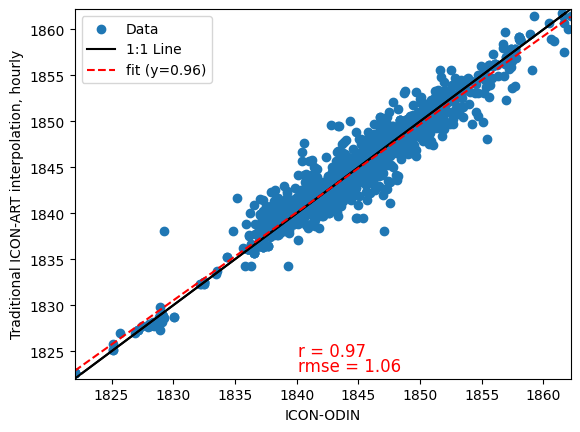

In [32]:
# Scatter plot with remapped obs, i.e. on ICON grid cells

x = remapped_xch4_odin
y = avg_icon

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)  # Create a mask for valid (non-NaN) entries
x_clean = x[mask]
y_clean = y[mask]

sorted_indices = np.argsort(x_clean)
x_sorted = x_clean[sorted_indices]
y_sorted = y_clean[sorted_indices]

x_clean = x_sorted
y_clean = y_sorted

# Fit a line (linear regression) with cleaned data
coeffs = np.polyfit(x_clean, y_clean, 1)  # First-order polynomial (linear fit)
slope, intercept = coeffs  # Slope (m) and intercept (b)
fitted_line = np.polyval(coeffs, x_clean)

# Compute the correlation coefficient
correlation_matrix = np.corrcoef(x_clean, y_clean)
r = correlation_matrix[0, 1]  # Extract correlation coefficient
rmse = np.sqrt(np.mean((x_clean - y_clean) ** 2))

fig, ax = plt.subplots()

# Plot scatter plot
plt.scatter(x_clean, y_clean, label="Data")
plt.plot(y_clean, y_clean, c='k')
plt.plot(x_clean, x_clean, c='k', label="1:1 Line")

# Add fitted line
plt.plot(x_clean, fitted_line, linestyle='--', color='red', label=f"fit (y={slope:.2f})")

# Add correlation coefficient as text
plt.text(0.45, 0.06, f'r = {r:.2f}', transform=ax.transAxes, color='red', fontsize=12)
plt.text(0.45, 0.02, f'rmse = {rmse:.2f}', transform=ax.transAxes, color='red', fontsize=12)

plt.xlim([np.nanmin([y_clean,x_clean]),np.nanmax([y_clean,x_clean])])
plt.ylim([np.nanmin([y_clean,x_clean]),np.nanmax([y_clean,x_clean])])

# Add legend and labels
plt.xlabel("ICON-ODIN")
plt.ylabel("Traditional ICON-ART interpolation, hourly")
plt.legend()
plt.show()


In [29]:
polygons = [Polygon(triangle) for triangle in corners_icon]
polygons_sel = [Polygon(triangle) for triangle in corners_obs_sel]


maxrerr = np.nanquantile(abs(Tdata_cleaned.obserror[:].values),0.999);
diff = avg_icon - remapped_xch4
diff_odin_icon = avg_icon - remapped_xch4_odin
maxdiffodin_icon = np.nanquantile(abs(diff_odin_icon),0.994);
maxdiff = np.nanquantile(abs(diff),0.994);
diff_odin_tropomi = remapped_xch4_odin - remapped_xch4
maxdiff_odin_tropomi = np.nanquantile(abs(diff_odin_tropomi),0.994);


gdf_remap = gpd.GeoDataFrame({'geometry': polygons, 'xch4': remapped_xch4})
gdf_remap.set_crs(epsg=4326, inplace=True)

gdf_avg = gpd.GeoDataFrame({'geometry': polygons, 'xch4': avg_icon})
gdf_avg.set_crs(epsg=4326, inplace=True)

gdf_err = gpd.GeoDataFrame({'geometry': polygons_sel, 'xch4': Tdata_cleaned.obserror[:].values})
gdf_err.set_crs(epsg=4326, inplace=True)

gdf_diff = gpd.GeoDataFrame({'geometry': polygons, 'xch4': diff})
gdf_diff.set_crs(epsg=4326, inplace=True)

gdf_diff_odin_icon = gpd.GeoDataFrame({'geometry': polygons, 'xch4': diff_odin_icon})
gdf_diff_odin_icon.set_crs(epsg=4326, inplace=True)

gdf_diff_odin_tropomi = gpd.GeoDataFrame({'geometry': polygons, 'xch4': diff_odin_tropomi})
gdf_diff_odin_tropomi.set_crs(epsg=4326, inplace=True)

gdf_odin = gpd.GeoDataFrame({'geometry': polygons, 'xch4': remapped_xch4_odin})
gdf_odin.set_crs(epsg=4326, inplace=True)


gdf_remap = gdf_remap.to_crs("EPSG:4326")
gdf_avg   = gdf_avg.to_crs("EPSG:4326")
gdf_err   = gdf_err.to_crs("EPSG:4326")
gdf_diff  = gdf_diff.to_crs("EPSG:4326")
gdf_diff_odin_icon = gdf_diff_odin_icon.to_crs("EPSG:4326")
gdf_diff_odin_tropomi = gdf_diff_odin_tropomi.to_crs("EPSG:4326")
gdf_odin = gdf_odin.to_crs("EPSG:4326")



gdf_countries = get_natural_earth.get_natural_earth(
            plotdir,resolution="10m", category="cultural", name="admin_0_countries"
        )
# Crop the countries to the grid
minlon, maxlon, minlat, maxlat = 19.30, 30.30, 43.05, 48.75
gdf_countries = gdf_countries.cx[minlon:maxlon, minlat:maxlat].clip_by_rect(
    minlon, minlat, maxlon, maxlat
)

gdf_countries = gdf_countries.to_crs("EPSG:4326")

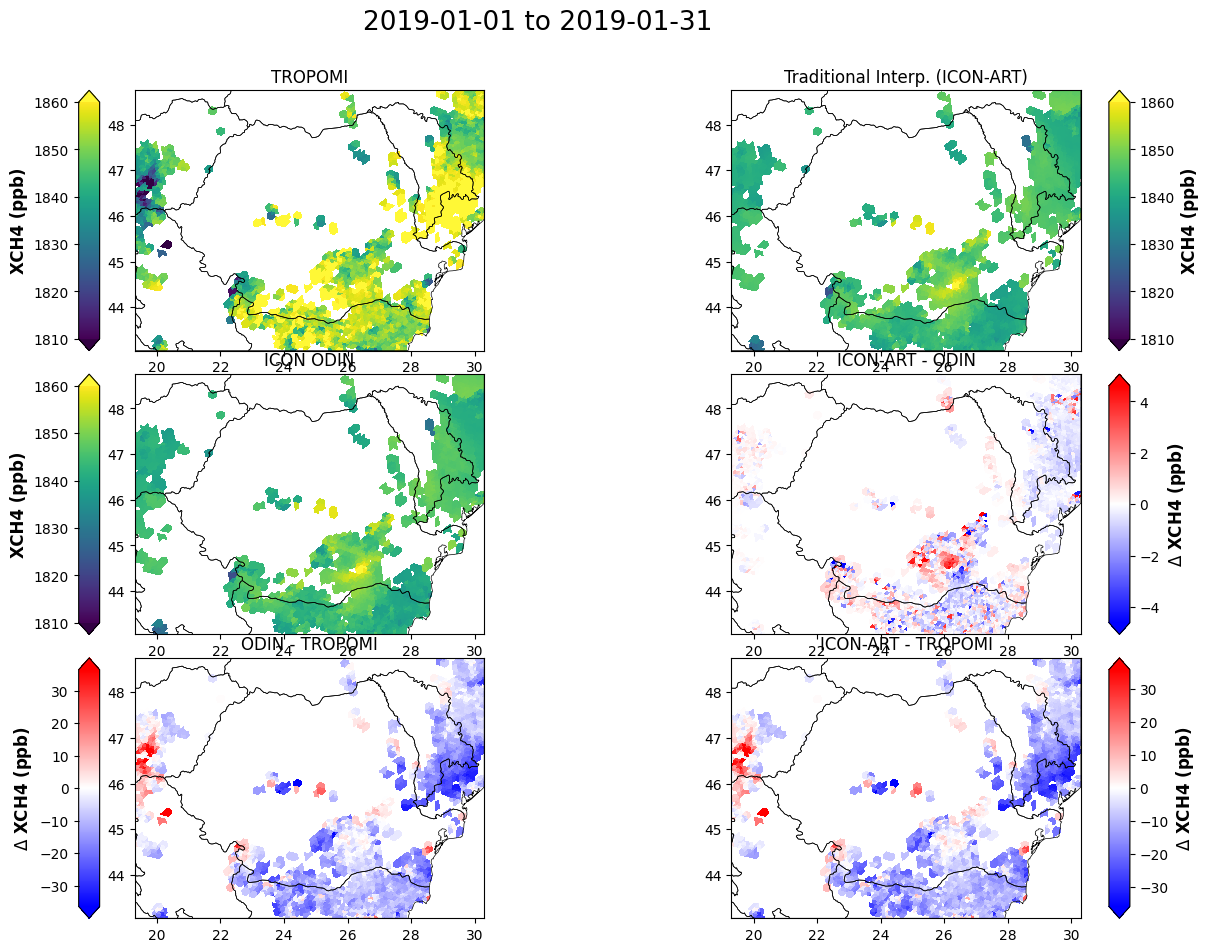

In [34]:
cmap  = plt.cm.viridis
cmapd = plt.cm.bwr
cmape = plt.cm.RdYlBu_r

cmap.set_under('#330043')
cmap.set_over('#FFF836')

vmin, vmax = 1810, 1860


fig, axes = plt.subplots(3, 2, figsize=(14, 9))

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

gdf_borders = gdf_countries.cx[minlon-1:maxlon+1, minlat-1:maxlat+1]
gdf_borders = gdf_borders.to_crs("EPSG:4326")

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    gdf_borders.boundary.plot(ax=ax, color='black', linewidth=0.5)
    ax.set_xlim(minlon, maxlon)
    ax.set_ylim(minlat, maxlat)
    ax.set_aspect('equal')
    

# Plot TROPOMI CH4
ax1.set_title("TROPOMI", fontsize=12)
gdf_remap.plot(column='xch4', cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0, edgecolor='none',  antialiased=False, ax=ax1)
mc1 = ax1.collections[1]

# # Plot ICON-ART CH4
ax2.set_title("Traditional Interp. (ICON-ART)", fontsize=12)
gdf_avg.plot(column='xch4', cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0, edgecolor='none', antialiased=False, ax=ax2)
mc2 = ax2.collections[1]

ax3.set_title("ICON ODIN", fontsize=12)
gdf_odin.plot(column='xch4', cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0, edgecolor='none', antialiased=False, ax=ax3)
mc3 = ax3.collections[1]

# # Plot ERROR
# ax3.set_title("PRECISION", fontsize=15)
# gdf_err.plot(column='xch4', cmap=cmape, vmin=0., vmax=maxrerr, linewidth=0, edgecolor='none', antialiased=False, ax=ax3)
# mc3 = ax3.collections[1]

ax4.set_title("ICON-ART - ODIN", fontsize=12)
gdf_diff_odin_icon.plot(column='xch4', cmap=cmapd, vmin=-maxdiffodin_icon, vmax=maxdiffodin_icon, linewidth=0, edgecolor='none', antialiased=False, ax=ax4)
mc4 = ax4.collections[1]

ax5.set_title("ODIN - TROPOMI", fontsize=12)
gdf_diff_odin_tropomi.plot(column='xch4', cmap=cmapd, vmin=-maxdiff_odin_tropomi, vmax=maxdiff_odin_tropomi, linewidth=0, edgecolor='none', antialiased=False, ax=ax5)
mc5 = ax5.collections[1]

# # Plot DIFF
ax6.set_title("ICON-ART - TROPOMI", fontsize=12)
gdf_diff.plot(column='xch4', cmap=cmapd, vmin=-maxdiff, vmax=maxdiff, linewidth=0, edgecolor='none', antialiased=False, ax=ax6)
mc6 = ax6.collections[1]


plt.subplots_adjust(bottom=0.01,top=0.93,left=0.08,right=0.92,hspace=0.09,wspace=0.03)

pos1 = ax1.get_position()
pos2 = ax2.get_position()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()
pos6 = ax6.get_position()
l1, b1, w1, h1 = pos1.x0, pos1.y0, pos1.width, pos1.height
l2, b2, w2, h2 = pos2.x0, pos2.y0, pos2.width, pos2.height
l3, b3, w3, h3 = pos3.x0, pos3.y0, pos3.width, pos3.height
l4, b4, w4, h4 = pos4.x0, pos4.y0, pos4.width, pos4.height
l5, b5, w5, h5 = pos5.x0, pos5.y0, pos5.width, pos5.height
l6, b6, w6, h6 = pos6.x0, pos6.y0, pos6.width, pos6.height




# Add a vertical colorbar on the top left, spanning full height
cbar_ax = fig.add_axes([l1-0.04, b1, 0.015, h1])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc1,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label="XCH4 (ppb)",size='large', weight='bold')
cbar.ax.yaxis.set_ticks_position("left"); cbar.ax.yaxis.set_label_position("left")


# Add a vertical colorbar on the top right, spanning full height
cbar_ax = fig.add_axes([l2+w2+0.02, b2, 0.015, h2])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc2,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label="XCH4 (ppb)",size='large', weight='bold')


# Add a vertical colorbar on the bottom left, spanning full height
cbar_ax = fig.add_axes([l3-0.04, b3, 0.015, h3])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc3,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label="XCH4 (ppb)",size='large', weight='bold')
cbar.ax.yaxis.set_ticks_position("left"); cbar.ax.yaxis.set_label_position("left")


# Add a vertical colorbar on the bottom right, spanning full height
cbar_ax = fig.add_axes([l4+w4+0.02, b4, 0.015, h4])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc4,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label=r"$\Delta$ XCH4 (ppb)",size='large', weight='bold')

# Add a vertical colorbar on the bottom left, spanning full height
cbar_ax = fig.add_axes([l5-0.04, b5, 0.015, h5])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc5,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label=r"$\Delta$ XCH4 (ppb)",size='large', weight='bold')
cbar.ax.yaxis.set_ticks_position("left"); cbar.ax.yaxis.set_label_position("left")

# Add a vertical colorbar on the bottom right, spanning full height
cbar_ax = fig.add_axes([l6+w6+0.02, b6, 0.015, h6])  # Manual positioning for colorbar
cbar = fig.colorbar(
    mc6,  # Use either plot (same color scale)
    cax=cbar_ax,  # Specify the axes for the colorbar
    orientation="vertical",
    extend = 'both',
)
cbar.set_label(label=r"$\Delta$ XCH4 (ppb)",size='large', weight='bold')


# Finalize the layout
plt.suptitle("%s to %s"%(dt.datetime.strftime(sdate,'%Y-%m-%d'),dt.datetime.strftime(edate,'%Y-%m-%d')),y=1.02,x=0.45,fontsize=19)
plt.show()
